In [48]:
# Import packages

import sqlite3
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# connect to database 
conn = sqlite3.connect('./mock_resq.db')
cursor = conn.cursor()

In [3]:
# Execute SQL query to fetch unique years from the createdAt column
cursor.execute("SELECT DISTINCT strftime('%Y', CreatedAt) AS Year FROM orders")

# Fetch the results
unique_years = cursor.fetchall()

In [70]:
def get_holidays(year):
    """
    Retrieves holiday dates for a given year using date.nager.at API.

    Args:
        year (str): A year as a string (e.g., '2022').

    Returns:
        list: A list of holiday dates for the given year.
    """
    try:
        response = requests.get(f'https://date.nager.at/api/v3/publicholidays/{year}/fi')
        response.raise_for_status()  # Raise an error for non-200 status codes
        holidays_data = response.json()
        return [holiday['date'] for holiday in holidays_data]
    except requests.RequestException as e:
        print(f"Error fetching holidays for {year}: {e}")
        return []


In [71]:
"""
This function creates a DataFrame that contains holiday dates for each year in the input list.

Args:
    unique_years (list): A list of unique years for which to get holiday dates.

Returns:
    all_holiday_dates (DataFrame): A DataFrame containing all holiday dates for the given years.
"""

def create_holiday_date(unique_years):
    # Get the number of unique years
    n = len(unique_years)
    
    # Initialize an empty DataFrame to store all holiday dates
    all_holiday_dates = pd.DataFrame()
    
    # Loop over each unique year
    for i in range(n):
        # Get the holiday dates for the current year
        holiday_dates = get_holidays(unique_years[i][0])
        
        # Create a DataFrame for the current year's holiday dates
        year_holiday_dates = pd.DataFrame({'holyDate': holiday_dates})
        
        # Concatenate the current year's holiday dates to the DataFrame of all holiday dates
        all_holiday_dates = pd.concat([all_holiday_dates, year_holiday_dates])
        
    # Return the DataFrame of all holiday dates
    all_holiday_dates.to_csv("all_holiday_dates.csv")
    all_holiday_dates['holyDate'] = pd.to_datetime(all_holiday_dates['holyDate'])
    return all_holiday_dates


In [74]:
def create_holiday_date(unique_years):
    """
    Creates a DataFrame containing holiday dates for each year in the input list.

    Args:
        unique_years (list): A list of unique years for which to get holiday dates.

    Returns:
        DataFrame: A DataFrame containing all holiday dates for the given years.
    """
    all_holiday_dates = pd.DataFrame()

    for year in unique_years:
        holiday_dates = get_holidays(str(year[0]))
        year_holiday_dates = pd.DataFrame({'holyDate': holiday_dates})
        all_holiday_dates = pd.concat([all_holiday_dates, year_holiday_dates], ignore_index=True)

    all_holiday_dates['holyDate'] = pd.to_datetime(all_holiday_dates['holyDate'])
    all_holiday_dates.to_csv("all_holiday_dates.csv", index=False)
    return all_holiday_dates


all_holiday_dates = create_holiday_date(unique_years)


In [18]:
all_holiday_dates = create_holiday_date(unique_years)

In [26]:
all_holiday_dates['holyDate'] = pd.to_datetime(all_holiday_dates['holyDate'])

In [10]:
query_orders = "SELECT * FROM orders"
orders = pd.read_sql_query(query_orders, conn)

In [12]:
orders['createdAt'] = pd.to_datetime(orders['createdAt'])

In [13]:
orders['date'] = pd.to_datetime(orders['createdAt'].dt.date)

In [29]:
orders['is_holiday'] = orders['date'].apply(lambda x: 1 if x in all_holiday_dates.values else 0)

In [32]:
orders['sales'] = orders['sales'].astype('Int64')

In [56]:
holiday_sales = orders[orders['is_holiday'] == 1]['sales'].mean()
non_holiday_sales = orders[orders['is_holiday'] == 0]['sales'].mean()
mean_holidays_sales_each = pd.DataFrame(orders[orders['is_holiday'] == 1].groupby('date')['sales'].mean())

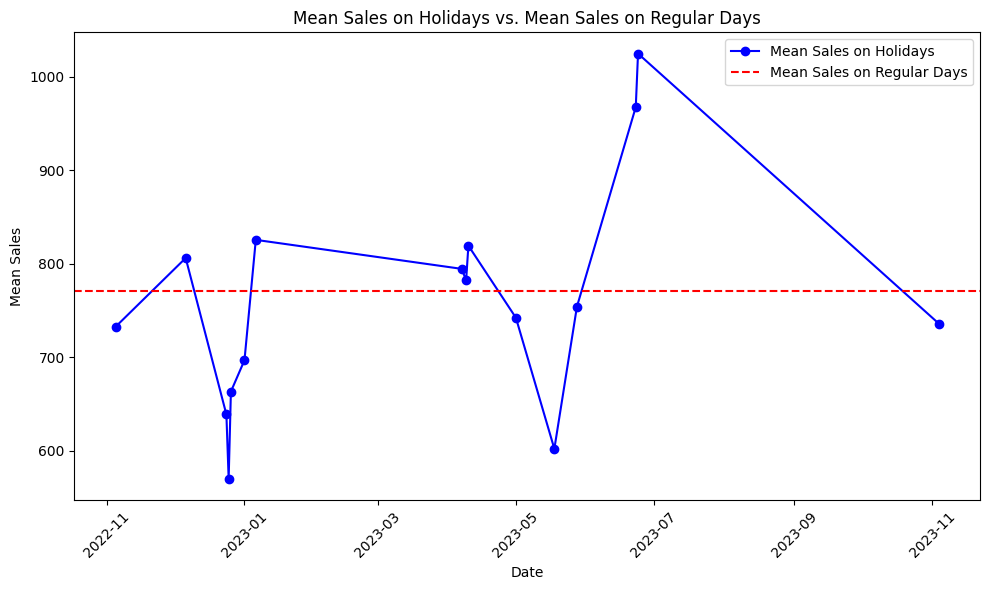

In [49]:
holiday_dates = mean_holidays_sales_each.index
holiday_sales = mean_holidays_sales_each['sales']

# Creating a plot for mean sales on each holiday date
plt.figure(figsize=(10, 6))
plt.plot(holiday_dates, holiday_sales, marker='o', linestyle='-', color='blue', label='Mean Sales on Holidays')

# Plotting a line for the mean sales on regular days
plt.axhline(y=non_holiday_sales, color='red', linestyle='--', label='Mean Sales on Regular Days')

# Labeling the plot
plt.title('Mean Sales on Holidays vs. Mean Sales on Regular Days')
plt.xlabel('Date')
plt.ylabel('Mean Sales')
plt.legend()
plt.xticks(rotation=45)  # Rotating x-axis labels for better readability

plt.tight_layout()
plt.show()

In [50]:
holiday_providers = orders[orders['is_holiday'] == 1]['providerId'].nunique()
non_holiday_providers = orders[orders['is_holiday'] == 0]['providerId'].nunique()


In [53]:
holiday_users = orders[orders['is_holiday'] == 1]['userId'].nunique()
non_holiday_users = orders[orders['is_holiday'] == 0]['userId'].nunique()

In [57]:
report = {
    "Average Sales on Public Holidays": holiday_sales,
    "Average Sales on Regular Days": non_holiday_sales,
    "Selling Providers on Public Holidays": holiday_providers,
    "Selling Providers on Regular Days": non_holiday_providers,
    "Purchasing Users on Public Holidays": holiday_users,
    "Purchasing Users on Regular Days": non_holiday_users
}

print("Analysis Results:")
for key, value in report.items():
    print(f"{key}: {value}")


Analysis Results:
Average Sales on Public Holidays: 762.0552652733119
Average Sales on Regular Days: 770.5013712096816
Selling Providers on Public Holidays: 1206
Selling Providers on Regular Days: 3561
Purchasing Users on Public Holidays: 4622
Purchasing Users on Regular Days: 122007


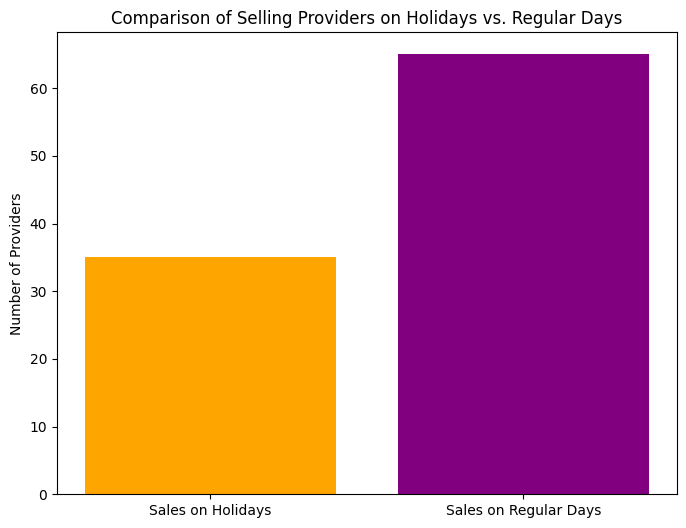

In [67]:
# Data for provider comparison
providers_data = [holiday_providers, non_holiday_providers]
labels = ['Sales on Holidays', 'Sales on Regular Days']

plt.figure(figsize=(8, 6))
plt.bar(labels, providers_data, color=['orange', 'purple'])
plt.title('Comparison of Selling Providers on Holidays vs. Regular Days')
plt.ylabel('Number of Providers')
plt.show()


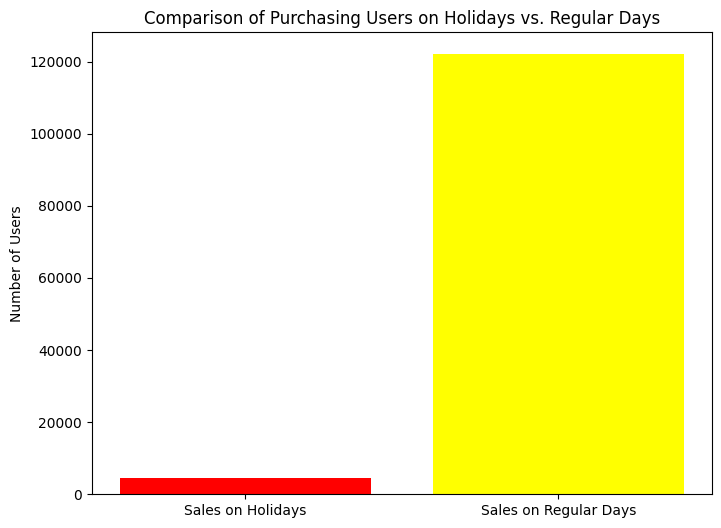

In [68]:
# Data for user comparison
users_data = [holiday_users, non_holiday_users]

plt.figure(figsize=(8, 6))
plt.bar(labels, users_data, color=['red', 'yellow'])
plt.title('Comparison of Purchasing Users on Holidays vs. Regular Days')
plt.ylabel('Number of Users')
plt.show()
